In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
#import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score

sys.path.append('../experiments/')
results = []

results_dir = f'../interv_results'
experiment_filename = '../experiments/new_distillation_tbm.py'

# load the results in to a pandas dataframe
r = imodelsx.process_results.get_results_df(results_dir)
cols_varied = imodelsx.process_results.get_experiment_keys(
    r, experiment_filename)
print('experiment varied these params:', cols_varied)
r = imodelsx.process_results.fill_missing_args_with_default(
    r, experiment_filename)

# save results as csvs for backup
#r.to_csv('../results/csvs/distillation_cub.csv')

# get the breakdown of data in these groups
r.groupby(cols_varied).size()

ModuleNotFoundError: No module named 'imodelsx'

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
#import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score
import pickle

with open('../interv_results/714117bbdc9a72aab905c640a4c9a993b922d9ac937bd1b1a1123ba932bf021a/results.pkl', 'rb') as f:
    # Load the data from the file
    r = pickle.load(f)

In [4]:
r.iloc[[3, 6, 10],:].teacher_prediction_test_accuracy

AttributeError: 'collections.defaultdict' object has no attribute 'iloc'

In [14]:
r.iloc[[3, 6, 10],:][['distiller_distillation_train_accuracy',
       'distiller_distillation_test_accuracy',
       'distiller_prediction_train_accuracy',
       'distiller_prediction_test_accuracy',
       'teacher_prediction_train_accuracy', 'teacher_prediction_test_accuracy',
       'distiller_distillation_interv_train_accuracy',
       'distiller_distillation_interv_test_accuracy',
       'distiller_prediction_interv_train_accuracy',
       'distiller_prediction_interv_test_accuracy',
       'teacher_prediction_interv_train_accuracy',
       'teacher_prediction_interv_test_accuracy', 'student_name', 'gpu',
       'student_distillation_train_accuracy',
       'student_distillation_test_accuracy',
       'student_prediction_train_accuracy', 'student_prediction_test_accuracy',
       'student_distillation_adap_interv_train_accuracy',
       'student_distillation_adap_interv_test_accuracy',
       'student_prediction_adap_interv_train_accuracy',
       'student_prediction_adap_interv_test_accuracy',
       'teacher_prediction_adap_interv_train_accuracy',
       'teacher_prediction_adap_interv_test_accuracy',
       'student_distillation_rand_interv_train_accuracy',
       'student_distillation_rand_interv_test_accuracy',
       'student_prediction_rand_interv_train_accuracy',
       'student_prediction_rand_interv_test_accuracy',
       'teacher_prediction_rand_interv_train_accuracy',
       'teacher_prediction_rand_interv_test_accuracy']].mean()

/tmp/ipykernel_12465/3030996048.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  r.iloc[[3, 6, 10],:][['distiller_distillation_train_accuracy',


distiller_distillation_train_accuracy                   NaN
distiller_distillation_test_accuracy                    NaN
distiller_prediction_train_accuracy                     NaN
distiller_prediction_test_accuracy                      NaN
teacher_prediction_train_accuracy                  0.939561
teacher_prediction_test_accuracy                   0.830917
distiller_distillation_interv_train_accuracy            NaN
distiller_distillation_interv_test_accuracy             NaN
distiller_prediction_interv_train_accuracy              NaN
distiller_prediction_interv_test_accuracy               NaN
teacher_prediction_interv_train_accuracy                NaN
teacher_prediction_interv_test_accuracy                 NaN
gpu                                                1.000000
student_distillation_train_accuracy                0.809492
student_distillation_test_accuracy                 0.705040
student_prediction_train_accuracy                  0.801638
student_prediction_test_accuracy        

In [99]:
r.loc[[0, 1, 2, 3, 4, 7], ['max_trees', 'distiller_distillation_train_accuracy',
       'distiller_distillation_test_accuracy',
       'distiller_prediction_train_accuracy',
       'distiller_prediction_test_accuracy',
       'teacher_prediction_train_accuracy', 'teacher_prediction_test_accuracy',
       'distiller_distillation_interv_train_accuracy',
       'distiller_distillation_interv_test_accuracy',
       'distiller_prediction_interv_train_accuracy',
       'distiller_prediction_interv_test_accuracy',
       'teacher_prediction_interv_train_accuracy',
       'teacher_prediction_interv_test_accuracy']].groupby('max_trees').mean()

,distiller_distillation_train_accuracy,distiller_distillation_test_accuracy,distiller_prediction_train_accuracy,distiller_prediction_test_accuracy,teacher_prediction_train_accuracy,teacher_prediction_test_accuracy,distiller_distillation_interv_train_accuracy,distiller_distillation_interv_test_accuracy,distiller_prediction_interv_train_accuracy,distiller_prediction_interv_test_accuracy,teacher_prediction_interv_train_accuracy,teacher_prediction_interv_test_accuracy
max_trees,,,,,,,,,,,,
20,0.936776,0.807905,0.935940,0.724197,0.99844,0.812565,0.742034,0.607813,0.939728,0.771545,0.751281,0.599586
30,0.927028,0.800196,0.926248,0.718444,0.99844,0.812565,0.732565,0.601312,0.928420,0.765044,0.751448,0.598493


In [76]:
r.distiller_prediction_test_accuracy.mean()

0.7659072603843056

In [78]:
r.distiller_prediction_test_accuracy.mean()

0.7658497296053389

In [71]:
np.mean(r.squeeze(axis=0).distiller_prediction_interv_test_accuracy) - np.mean(r.squeeze(axis=0).distiller_prediction_test_accuracy)

0.03308019790587968

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
#import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score
import pickle

with open('../interv_results/714117bbdc9a72aab905c640a4c9a993b922d9ac937bd1b1a1123ba932bf021a/results.pkl', 'rb') as f:
    # Load the data from the file
    r = pickle.load(f)

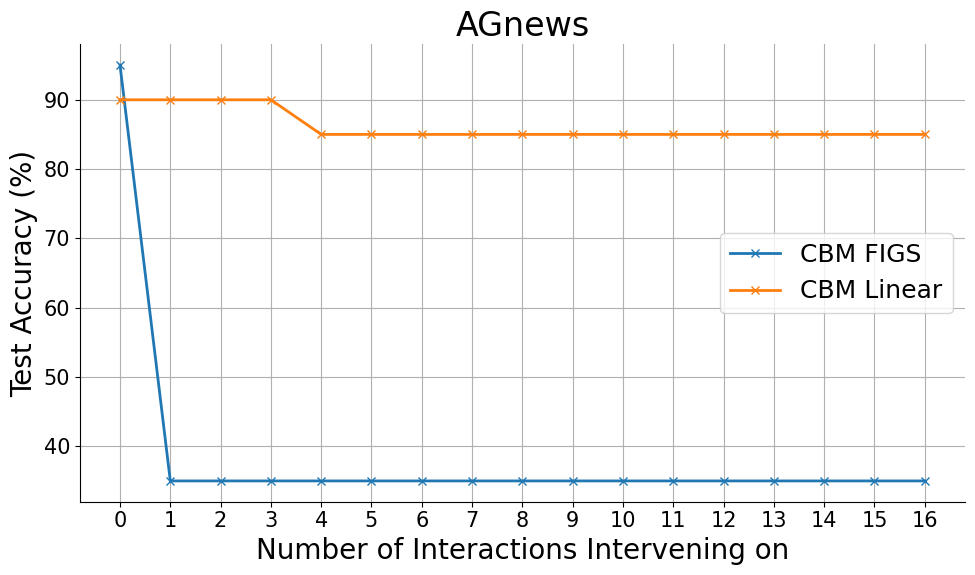

In [17]:
#linear = r.iloc[X, :] #TODO: make sure this is linear experiment
linear = r
num_iters = linear['num_interactions_intervention'] if linear['num_interactions_intervention'] != 0 else linear['n_trees']
linear_plotting = [['teacher_prediction_test_accuracy']+
            [f'teacher_pred_lin_interv_iter{i}_test_accuracy' for i in range(num_iters)]]
figs_plotting = [['student_prediction_test_accuracy']+
                [f'student_pred_adap_interv_iter{i}_test_accuracy' for i in range(num_iters)]]

def get_data_from_list(r, var_list):
    arr = [r[x] for x in var_list]
    return np.array(arr)

#t_l_pred = linear[linear_plotting[0]].to_numpy()
#s_a_pred = linear[figs_plotting[0]].to_numpy()

t_l_pred = get_data_from_list(r, linear_plotting[0])
s_a_pred = get_data_from_list(r, figs_plotting[0])

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.titlesize'] = 24
# Define x-axis range
x = np.arange(0, num_iters+1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_pred)*100, label='CBM FIGS', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='CBM Linear', linewidth=2, marker='x')
plt.xticks(x)
# Labels and legend
plt.xlabel("Number of Interactions Intervening on", fontsize = 20)
#plt.ylim(70, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 20)
plt.title("AGnews")
plt.legend(fontsize = 18)
plt.grid(True)

# Show the plot
#plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/CUB_aTTI_Effect.png', bbox_inches='tight')

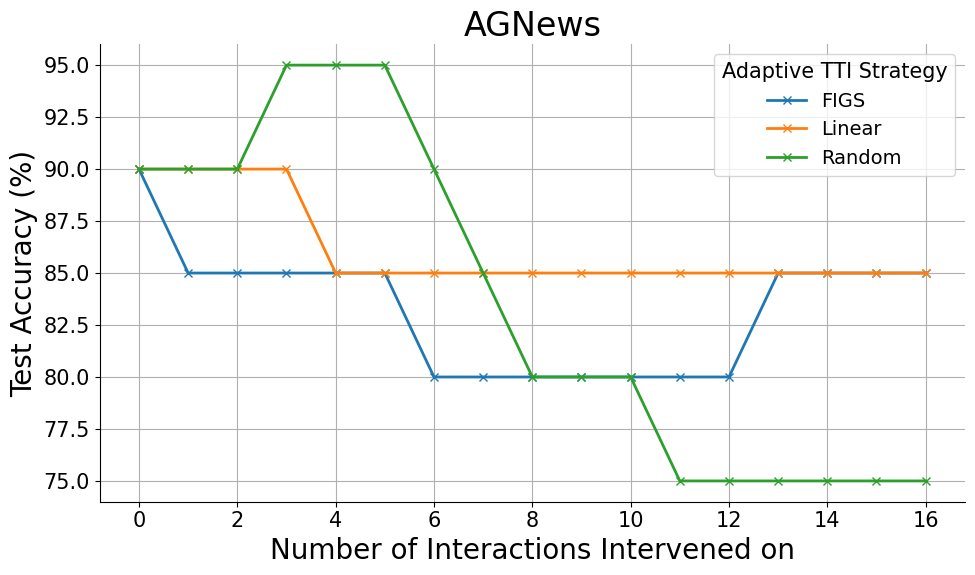

In [18]:
plt.rcParams['axes.titlesize'] = 24
# Define x-axis range
#linear = r.iloc[X, :] #TODO: make sure this is linear experiment

#num_iters = linear.num_interactions_intervention if linear.num_interactions_intervention != 0 else linear.n_trees
t_l_pred = [['teacher_prediction_test_accuracy']+
            [f'teacher_pred_lin_interv_iter{i}_test_accuracy' for i in range(num_iters)]]
t_a_pred = [['teacher_prediction_test_accuracy']+
                [f'teacher_pred_adap_interv_iter{i}_test_accuracy' for i in range(num_iters)]]
t_r_pred = [['teacher_prediction_test_accuracy']+
                [f'teacher_pred_rand_interv_iter{i}_test_accuracy' for i in range(num_iters)]]

#t_l_pred = linear[t_l_pred[0]].to_numpy()
#t_a_pred = linear[t_a_pred[0]].to_numpy()
#t_r_pred = linear[t_r_pred[0]].to_numpy()

t_l_pred = get_data_from_list(r, t_l_pred[0])
t_a_pred = get_data_from_list(r, t_a_pred[0])
t_r_pred = get_data_from_list(r, t_r_pred[0])

x = np.arange(0, num_iters+1)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(t_a_pred)*100, label='FIGS', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='Linear', linewidth=2, marker='x')
plt.plot(x, np.array(t_r_pred)*100, label='Random', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on", fontsize = 20)
#plt.ylim(70, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 20)
plt.title("AGNews")
plt.legend(title='Adaptive TTI Strategy', fontsize = 14)
plt.grid(True)

# Show the plot
#plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/CUB_aTTI_Effect_Diff.png', bbox_inches='tight')

In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
#import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score
import pickle

with open('../interv_results/5842539d02935b0061fe1372f7ca9b8ab2486620f790fbabe72c759db08418b8/results.pkl', 'rb') as f:
    # Load the data from the file
    r = pickle.load(f)

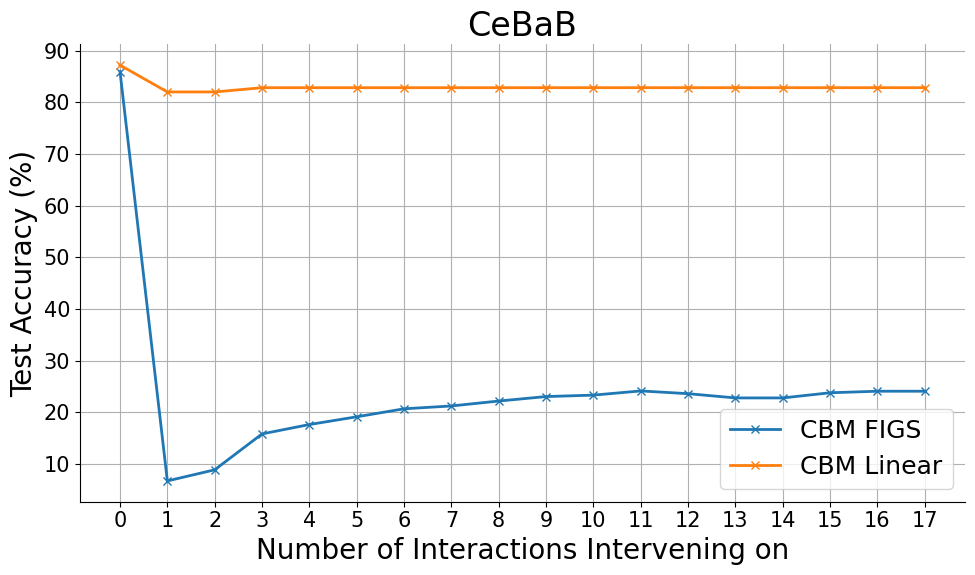

In [21]:
#linear = r.iloc[X, :] #TODO: make sure this is linear experiment
linear = r
num_iters = linear['num_interactions_intervention'] if linear['num_interactions_intervention'] != 0 else linear['n_trees']
linear_plotting = [['teacher_prediction_test_r2']+
            [f'teacher_pred_lin_interv_iter{i}_test_r2' for i in range(num_iters)]]
figs_plotting = [['student_prediction_test_r2']+
                [f'student_pred_adap_interv_iter{i}_test_r2' for i in range(num_iters)]]

def get_data_from_list(r, var_list):
    arr = [r[x] for x in var_list]
    return np.array(arr)

#t_l_pred = linear[linear_plotting[0]].to_numpy()
#s_a_pred = linear[figs_plotting[0]].to_numpy()

t_l_pred = get_data_from_list(r, linear_plotting[0])
s_a_pred = get_data_from_list(r, figs_plotting[0])

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.titlesize'] = 24
# Define x-axis range
x = np.arange(0, num_iters+1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_pred)*100, label='CBM FIGS', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='CBM Linear', linewidth=2, marker='x')
plt.xticks(x)
# Labels and legend
plt.xlabel("Number of Interactions Intervening on", fontsize = 20)
#plt.ylim(70, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 20)
plt.title("CeBaB")
plt.legend(fontsize = 18)
plt.grid(True)

# Show the plot
#plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/CUB_aTTI_Effect.png', bbox_inches='tight')

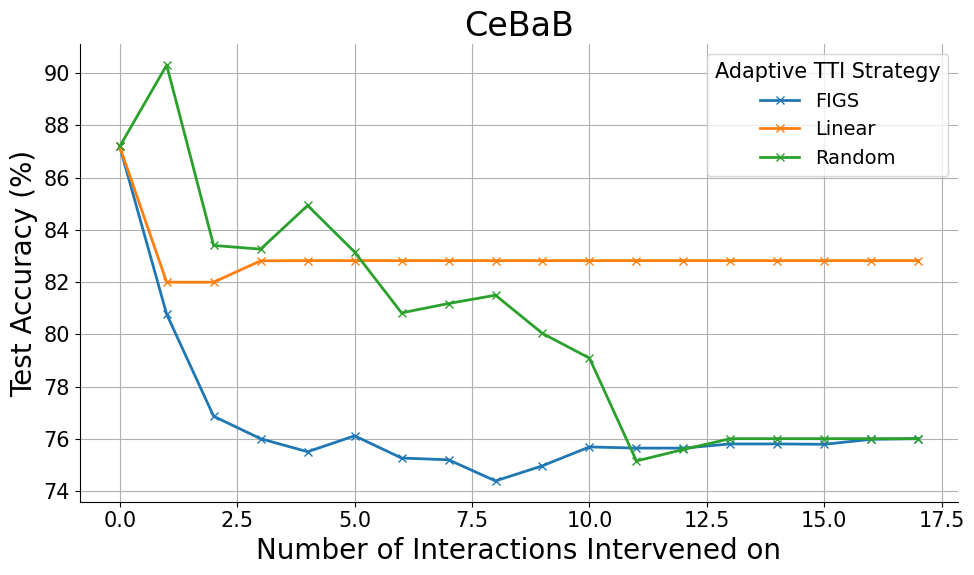

In [22]:
plt.rcParams['axes.titlesize'] = 24
# Define x-axis range
#linear = r.iloc[X, :] #TODO: make sure this is linear experiment

#num_iters = linear.num_interactions_intervention if linear.num_interactions_intervention != 0 else linear.n_trees
t_l_pred = [['teacher_prediction_test_r2']+
            [f'teacher_pred_lin_interv_iter{i}_test_r2' for i in range(num_iters)]]
t_a_pred = [['teacher_prediction_test_r2']+
                [f'teacher_pred_adap_interv_iter{i}_test_r2' for i in range(num_iters)]]
t_r_pred = [['teacher_prediction_test_r2']+
                [f'teacher_pred_rand_interv_iter{i}_test_r2' for i in range(num_iters)]]

#t_l_pred = linear[t_l_pred[0]].to_numpy()
#t_a_pred = linear[t_a_pred[0]].to_numpy()
#t_r_pred = linear[t_r_pred[0]].to_numpy()

t_l_pred = get_data_from_list(r, t_l_pred[0])
t_a_pred = get_data_from_list(r, t_a_pred[0])
t_r_pred = get_data_from_list(r, t_r_pred[0])

x = np.arange(0, num_iters+1)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(t_a_pred)*100, label='FIGS', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='Linear', linewidth=2, marker='x')
plt.plot(x, np.array(t_r_pred)*100, label='Random', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on", fontsize = 20)
#plt.ylim(70, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 20)
plt.title("CeBaB")
plt.legend(title='Adaptive TTI Strategy', fontsize = 14)
plt.grid(True)

# Show the plot
#plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/CUB_aTTI_Effect_Diff.png', bbox_inches='tight')